<a href="https://colab.research.google.com/github/hfarruda/deeplearningtutorial/blob/master/deepLearningLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Long Short-Term Memory (LSTM)

This is the third example of deep learning implementation. Here we use a LSTM network to predict the Bitcoin prices along time by using the input as a temporal series.


First of all, we import the necessary libraries. Here we opt for using Keras (using TensorFlow backend).

In [0]:
import numpy as np
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader

If you have a GPU, you can use the following code to allocate processing into it.  Otherwise, proceed to (*).

In [0]:
import tensorflow as tf 
from keras import backend as K

print(K.tensorflow_backend._get_available_gpus())

number_of_cpu_cores = 8
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': number_of_cpu_cores}) 
session = tf.Session(config=config) 
keras.backend.set_session(session)

['/job:localhost/replica:0/task:0/device:GPU:0']


(*) Here, we use the Bitcoin daily prices dataset, which is available at
[yhaoo-stock-market](https://finance.yahoo.com/). The data contains seven columns, organized as follows: date, opening stock price, high daily price, low daily price, closing stock price, the currency volume treaded on the day, and the adjusted closing price.

In [0]:
training_size = 1200
start_date = '2015-01-01'# Bitcoin started on '2010-07-16'

dataset =  pandas_datareader.data.get_data_yahoo("BTC-USD", start = start_date)
data_oerder = ['Open','High', 'Low', 'Close', 'Volume', 'Adj Close']
dataset = dataset[data_oerder]


training_dataset = dataset.iloc[0:training_size, 1::].values
test_dataset = dataset.iloc[training_size::, 1::].values

min_max_scaler = MinMaxScaler(feature_range=(0,1))
normalized_training_dataset = min_max_scaler.fit_transform(training_dataset)

min_max_scaler_training = MinMaxScaler(feature_range=(0,1))
normalized_training_price = min_max_scaler_training.fit_transform(training_dataset[:,0:1])


In the following we define the network topology.

In [0]:
window_size = 50
number_of_lstm_layers = 3
activation = 'sigmoid' 
return_sequences = True
units_first_layer = 100
units = 50

data = []
training_price = []
for i in range(window_size, training_size):
    data.append(normalized_training_dataset[i-window_size:i, 0:6])
    training_price.append(normalized_training_dataset[i, 0])
data, training_price = np.array(data), np.array(training_price)

lstm_model = Sequential()
lstm_model.add(LSTM(units = units_first_layer, 
                    return_sequences = return_sequences, 
                    input_shape = (data.shape[1], 5)))
lstm_model.add(Dropout(0.2))

for i in range(number_of_lstm_layers-2):
    lstm_model.add(LSTM(units = units, return_sequences = return_sequences))
    lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = units))
lstm_model.add(Dropout(0.2))

#Output layer
lstm_model.add(Dense(units = 1, activation = activation))

In order to check the network topology, you can use the subsequent command.

In [0]:
lstm_model.summary() 
#Saving the resultant figure as 'ff_model.png'.
plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True, 
           show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 100)           42400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 50)            30200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total para

The training step is executed as follows.



In [0]:
#Here we set verbose as true
verbose = 1

batch_size = 32
epochs = 10
filepath = 'weights.h5' #name of the file with the network weights
monitor = 'loss'
optimizer = 'adam'
loss = 'mean_squared_error'
metrics = ['mean_absolute_error'] 

lstm_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

early_stopping = EarlyStopping(monitor = monitor, min_delta = 1e-15, 
                               patience = 10, verbose = verbose)
reduce_learning_rate_on_plateau = ReduceLROnPlateau(monitor = monitor, 
                                                    factor = 0.2, patience = 5, 
                                                    verbose = verbose)
model_checkpoint = ModelCheckpoint(filepath = filepath, monitor = monitor, 
                      save_best_only = True, verbose = verbose)
lstm_model.fit(data, training_price, epochs = epochs, batch_size = batch_size,
              callbacks = [early_stopping, reduce_learning_rate_on_plateau, 
              model_checkpoint])

Epoch 1/10
1150/1150 [==============================] - 12s 10ms/step - loss: 0.0635 - mean_absolute_error: 0.1793

Epoch 00001: loss improved from inf to 0.06350, saving model to weights.h5
Epoch 2/10
1150/1150 [==============================] - 10s 9ms/step - loss: 0.0044 - mean_absolute_error: 0.0415

Epoch 00002: loss improved from 0.06350 to 0.00439, saving model to weights.h5
Epoch 3/10
1150/1150 [==============================] - 10s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0309

Epoch 00003: loss improved from 0.00439 to 0.00318, saving model to weights.h5
Epoch 4/10
1150/1150 [==============================] - 10s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0289

Epoch 00004: loss improved from 0.00318 to 0.00270, saving model to weights.h5
Epoch 5/10
1150/1150 [==============================] - 10s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0247

Epoch 00005: loss improved from 0.00270 to 0.00195, saving model to weights.h5
Epoch 6/10
1150/1150 [===========

The following code represents the test data in the network.

In [0]:
test_price = test_dataset[:, 0:1]
complete_dataset = dataset.iloc[:,1::]

training_data = complete_dataset[len(complete_dataset) - len(test_dataset) - 
                                 window_size:].values
training_data = min_max_scaler.transform(training_data)


X_test = []
for i in range(window_size,len(training_data)):
    X_test.append(training_data[i-window_size:i, 0:6])
X_test = np.array(X_test)

calculated_prices = lstm_model.predict(X_test)
calculated_prices = min_max_scaler_training.inverse_transform(calculated_prices)

training_price = min_max_scaler_training.inverse_transform([training_price])
training_price = training_price[0]

In the following, we plot the tournament set, as well as the previsions and the expected values.

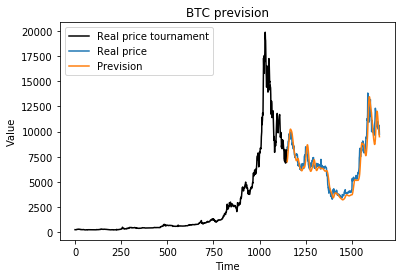

In [0]:
plt.plot(np.linspace(0,len(training_price)-1,len(training_price)), 
         training_price, label = 'Real price tournament', color = 'k')
plt.plot(np.linspace(len(training_price),len(training_price)+len(test_price)-1,
                     len(test_price)), test_price, label = 'Real price')
plt.plot(np.linspace(len(training_price),len(training_price)+len(test_price)-1,
                     len(test_price)), calculated_prices, label = 'Prevision')
plt.title('BTC prevision')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()